In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
tasks = {
    'binary': [0, 1], 
    'type': [0, 1, 2, 3]
}
representations = ['bow', 'freq', 'tfidf', 'bert']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['SMOTETomek', 'RandomOver', 'ADASYN', 'RandomUnder', 'none']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n\n\n')

In [ ]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    statistic, pvalue = scipy.stats.friedmanchisquare(overall_df.to_numpy())
    overall_df.loc[len(df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(overall_df)
    if pvalue <= THRESHOLD:
        columns = [df[column] for column in df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, df.columns.values)

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.


Task: Binary

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


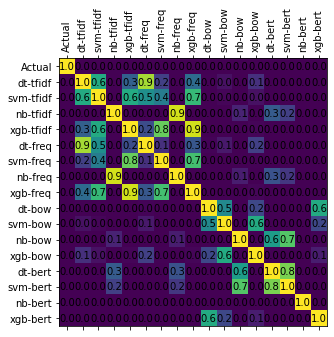

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-freq   0.869863  0.479651    0.674757  0.761475
xgb-tfidf  0.876712  0.468023    0.672368  0.598361
dt-freq    0.828767  0.508721    0.668744  0.596721
dt-tfidf   0.836758  0.500000    0.668379  0.767213
svm-freq   0.914384  0.392442    0.653413  0.751639
dt-bow     0.756849  0.517442    0.637146  0.703279
xgb-bow    0.818493  0.444767    0.631630  0.759836
svm-bert   0.623288  0.625000    0.624144  0.390164
svm-tfidf  0.948630  0.250000    0.599315  0.741803
svm-bow    0.855023  0.316860    0.585942  0.738525
xgb-bert   0.808219  0.351744    0.579982  0.689344
dt-bert    0.692922  0.430233    0.561577  0.713115
nb-bow     0.732877  0.369186    0.551031  0.630328
nb-freq    0.682648  0.377907    0.530278  0.623770
nb-tfidf   0.688356  0.369186    0.528771  0.618852
nb-bert    0.229452  0.799419    0.514435  0.679508

Mean: 0.6283477471906251



Task: binary. Grouping: ['bow', 'fr

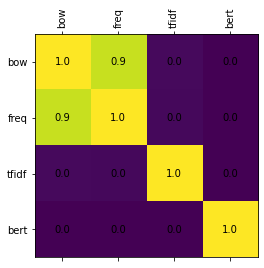

Scores: 
        Score 0   Score 1  Mean score
freq   0.928082  0.375000    0.651541
tfidf  0.944064  0.287791    0.615927
bert   0.770548  0.436047    0.603297
bow    0.897260  0.290698    0.593979

Mean: 0.6161861527025592





Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 6.342788370103978e-48
Post-hoc Dunn test array:


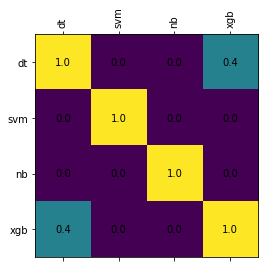

Scores: 
      Score 0   Score 1  Mean score
xgb  0.918950  0.386628    0.652789
dt   0.905251  0.395349    0.650300
svm  0.947489  0.261628    0.604558
nb   0.719178  0.357558    0.538368

Mean: 0.6115037963257938






Task: Type

Task: type.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


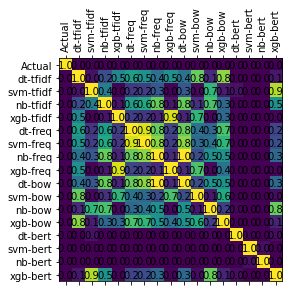

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.688235    0.000  0.410256  0.552846    0.412834  0.538235
xgb-freq   0.688235    0.000  0.410256  0.544715    0.410802  0.591176
dt-tfidf   0.664706    0.000  0.410256  0.504065    0.394757  0.573529
dt-freq    0.647059    0.000  0.358974  0.479675    0.371427  0.500000
dt-bow     0.641176    0.125  0.230769  0.487805    0.371188  0.402941
xgb-bow    0.676471    0.000  0.282051  0.504065    0.365647  0.588235
nb-freq    0.647059    0.000  0.282051  0.471545    0.350164  0.552941
nb-tfidf   0.676471    0.000  0.153846  0.439024    0.317335  0.526471
svm-bow    0.888235    0.000  0.000000  0.357724    0.311490  0.514706
nb-bow     0.670588    0.000  0.153846  0.406504    0.307735  0.526471
xgb-bert   0.682353    0.000  0.076923  0.382114    0.285347  0.535294
svm-freq   0.888235    0.000  0.000000  0.252033    0.285067  0.482353
svm-tf

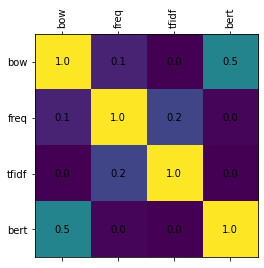

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
freq   0.882353      0.0  0.205128  0.325203    0.353171
bow    0.870588      0.0  0.153846  0.382114    0.351637
tfidf  0.888235      0.0  0.205128  0.252033    0.336349
bert   0.664706      0.0  0.076923  0.252033    0.248415

Mean: 0.3223931317367472





Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 2.338334310613831e-17
Post-hoc Dunn test array:


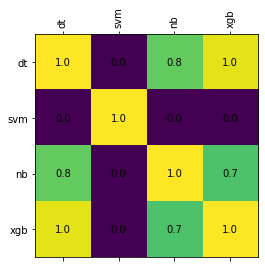

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
xgb  0.800000      0.0  0.410256  0.471545    0.420450
dt   0.723529      0.0  0.333333  0.422764    0.369907
nb   0.700000      0.0  0.153846  0.406504    0.315088
svm  0.917647      0.0  0.000000  0.113821    0.257867

Mean: 0.3408279071478497







In [10]:
for task in tasks:
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = temp_df.index
        overall_dfs[method] = temp_df['Mean score']
        algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)